#Exercise

The dataset is about the image data of natural scenes around the world. This dataset size 150 x 150 distributed under 6 categories as follows:




0 - buildings




1 - forest




2 - glacier




3 - mountain




4 - sea




5 - street




The train and test are separated in each files. 




Conduct an analysis using an appropriate deep learning model. You are required to improve the performance of the model.

Dataset content:

zip file->seg_train,seg_test -> buildings,forest,glacier, mountain,sea,street


Solution Reference: https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# First path in below cell - Your Google Drive location which you want to Unzip
# Second path in below cell - Path where you want to extract the zip file in Google Drive
import os.path
from os import path

extract_output_directory = '/drive/My Drive/apu-dl-datasets/nature'
if path.exists(extract_output_directory) == False:
  !unzip '/drive/My Drive/apu-dl-datasets/nature.zip' -d extract_output_directory
else:
  print('Path already exists')

Path already exists



Train and Test dataset
Each Image is 150 x 150 pixels.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling
from keras.utils import to_categorical, image_dataset_from_directory

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

img_height = 150
img_width = 150
batch_size = 32

train_ds = image_dataset_from_directory(
  extract_output_directory + '/nature/seg_train/seg_train',
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2700 files belonging to 6 classes.
Using 2430 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
  extract_output_directory + '/nature/seg_test/seg_test',
  validation_split=0.8,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 536 files belonging to 6 classes.
Using 428 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
class_names2 = val_ds.class_names
print(class_names2)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


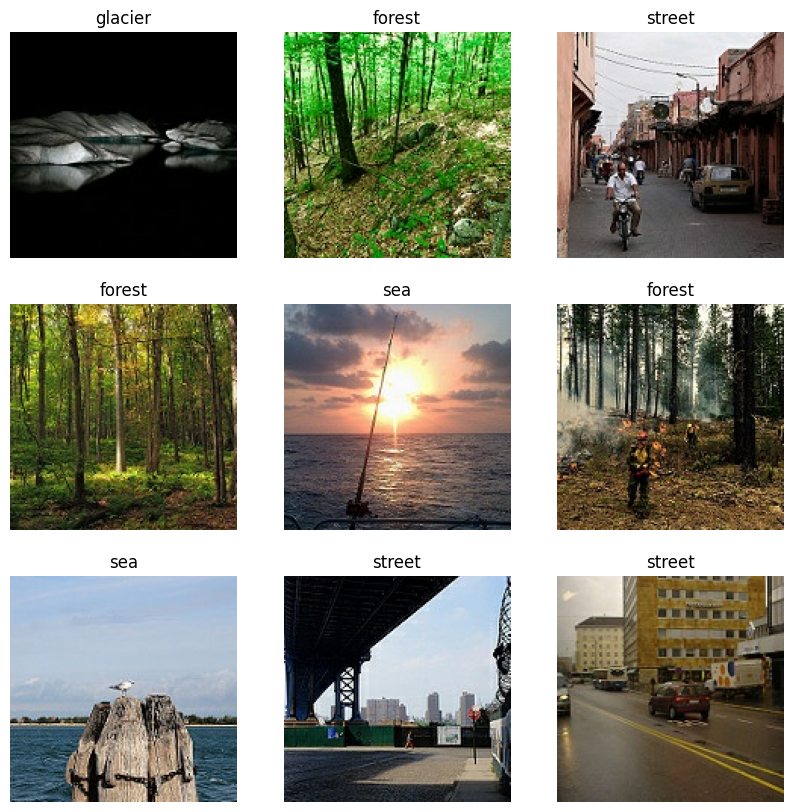

In [ ]:
# View first 9 images from the train_ds dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 150, 150, 3)
(32,)


In [ ]:


normalization_layer = tf.keras.layers.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

    Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the Image classification tutorial.

In [ ]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(num_classes)
])


Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)


Epoch 1/3
76/76 [==============================] - 93s 1s/step - loss: 1.4906 - accuracy: 0.4086 - val_loss: 1.2290 - val_accuracy: 0.5514
Epoch 2/3
76/76 [==============================] - 87s 1s/step - loss: 1.1668 - accuracy: 0.5473 - val_loss: 1.0742 - val_accuracy: 0.5841
Epoch 3/3
76/76 [==============================] - 89s 1s/step - loss: 1.0641 - accuracy: 0.5778 - val_loss: 1.1625 - val_accuracy: 0.5701


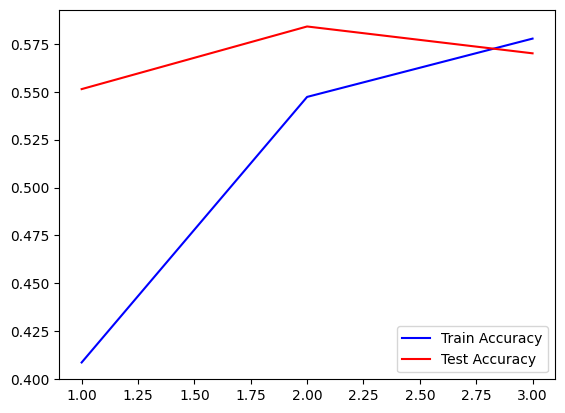

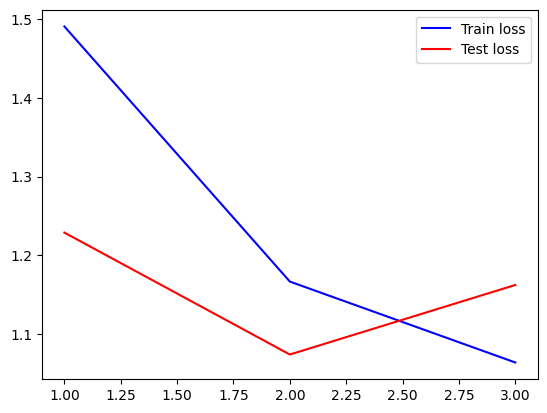

In [ ]:
# Visualisations

import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# 'b' and 'r' are blue and red color

plt.plot(epochs, acc2, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss2, 'b', label = 'Train loss')
plt.plot(epochs, val_loss, 'r', label = 'Test loss')
plt.legend()
plt.show()